# Training Notebook

In [1]:
import glob
import os
import numpy as np
import time

# Vision
import cv2

## Utility
import xml.etree.ElementTree as ET
from tqdm import tqdm

import inference_utils

## Displaying in-cell
from IPython.display import Image
import matplotlib.pyplot as plt

## Analysis
from collections import Counter

%load_ext lab_black

In [2]:
DOWNLOAD_DIR = os.path.join("/Users", "apowell", "Downloads")
assert os.path.isdir(DOWNLOAD_DIR)

DATA_DIR = os.path.join("..", "data", "Herring")

# Set path to training and test
TRAINING_DIR = os.path.join(DATA_DIR, "Training", "IRWA 2017 (Large+annotations)")
TESTING_DIR = os.path.join(DATA_DIR, "Testing")

os.path.isdir(DATA_DIR)  # assertion that we are pointed to correct folder
WEIGHTS_DIR = os.path.join("..", "weights_and_config")
HERRING_WEIGHTS = os.path.join(WEIGHTS_DIR, "Herring")

Inference time on image: 0.53
[] 0 () []


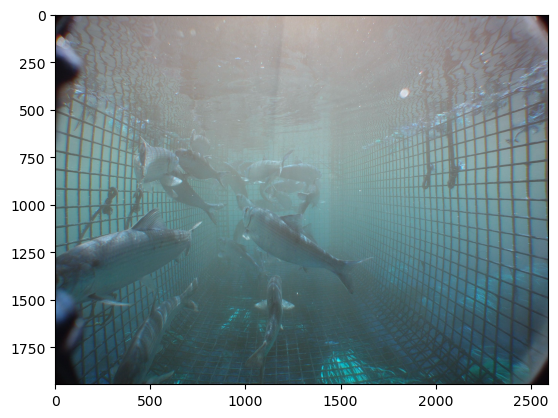

In [7]:
# Initialize model and set paths
model_config = os.path.join(HERRING_WEIGHTS, "herring.cfg")
model_weights = os.path.join(HERRING_WEIGHTS, "herring_final.weights")
# Initialize model
c = inference_utils.FishCounter(model_config=model_config, model_weights=model_weights)

# Test image
herring_image = "/Users/apowell/Downloads/BJ-Xdgso.jpeg"
c.load_image(image=herring_image)
boxes, counts, ind, class_ids = c.process_frame(time_inference=True)
print(boxes, counts, ind, class_ids)
# Sanity-check with annotated frame
c.get_annotated_frame()

In [24]:
def get_dimensions_of_annotations(fpath):
    """Extracts dimensions of annotation boxes from xml file for image."""

    class_label = "herring"  # TODO: Will need to accomodate multiple classes

    tree = ET.parse(fpath)
    root = tree.getroot()

    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    for o in root.iter("object"):
        if o.find("name").text == class_label:
            xmins.append(eval(o[4][0].text))
            ymins.append(eval(o[4][1].text))
            xmaxs.append(eval(o[4][2].text))
            ymaxs.append(eval(o[4][3].text))
    return xmins, ymins, xmaxs, ymaxs


def bb_intersection_over_union(boxA, boxB):
    """Compute the intersection over union by taking the intersection area and dividing
    it by the sum of prediction + ground-truth areas - the interesection area"""
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    print(interArea)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    print(boxAArea)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    print(boxBArea)

    return interArea / float(boxAArea + boxBArea - interArea)


def find_matching_path(annotations, images):
    """Finds the corresponding image or annotation path (i.e. given on path searches for the corresponding path)"""
    if type(annotations) == str:
        anchor, search = annotations, images
    elif type(images) == str:
        anchor, search = images, annotations
    else:
        print("Somethings wrong")
    return [p for p in search if anchor.split("/")[-1].split(".")[0] in p][
        0
    ]  # only need one

#### Set paths

In [56]:
folder = "Batch "
# Load images and annotations
# images_path1 = os.path.join(TRAINING_DIR, folder, "*.JPG")
# images_path2 = os.path.join(TRAINING_DIR, folder, "*.jpg")
images_path1 = os.path.join(DOWNLOAD_DIR, "HerringTrainingSet", "Images", "*.jpg")
images = glob.glob(images_path1)  # + glob.glob(images_path2)

# annotation_path = os.path.join(TRAINING_DIR, f"{folder} Annotations", "*.xml")
annotation_path = os.path.join(DOWNLOAD_DIR, "HerringTrainingSet", "Xml", "*.xml")
annotations = glob.glob(annotation_path)
print("{} images. Annotations: {}".format(len(images), len(annotations)))

1111 images. Annotations: 1111


In [55]:
folder = "Batch 2"
# Load images and annotations
# images_path1 = os.path.join(TRAINING_DIR, folder, "*.JPG")
# images_path2 = os.path.join(TRAINING_DIR, folder, "*.jpg")
images_path1 = os.path.join(
    DOWNLOAD_DIR, "IRWA 2017 (Large+annotations)-2", "New Training Set", "*.png"
)
images = glob.glob(images_path1)  # + glob.glob(images_path2)

# annotation_path = os.path.join(TRAINING_DIR, f"{folder} Annotations", "*.xml")
annotation_path = os.path.join(
    DOWNLOAD_DIR,
    "IRWA 2017 (Large+annotations)-2",
    "New Training Set",
    "annotations",
    "*.xml",
)
print(annotation_path)
annotations = glob.glob(annotation_path)
print("{} images. Annotations: {}".format(len(images), len(annotations)))

/Users/apowell/Downloads/IRWA 2017 (Large+annotations)-2/New Training Set/annotations/*.xml
94 images. Annotations: 94


In [33]:
os.listdir(os.path.join(DATA_DIR, "Training", "IRWA 2017 (Large+annotations)"))

['IRWA Small Jpgs', '.DS_Store', 'Images', 'New Training Set', 'Annotations']

In [57]:
images = glob.glob(
    os.path.join(
        DATA_DIR, "Training", "IRWA 2017 (Large+annotations)", "Images", "*.jpg"
    )
)
annotations = glob.glob(
    os.path.join(
        DATA_DIR, "Training", "IRWA 2017 (Large+annotations)", "Annotations", "*.xml"
    )
)

print("{} images. Annotations: {}".format(len(images), len(annotations)))

234 images. Annotations: 198


In [14]:
# Example: Finding matching paths
test = images[0]
print("test:", test)
test_match = find_matching_path(images=test, annotations=annotations)
print("test match:", test_match)

test: /Users/apowell/Downloads/HerringTestSet/Images/1_2016-04-21_21-50-1808716.jpg
test match: /Users/apowell/Downloads/HerringTestSet/Xml/1_2016-04-21_21-50-1808716.xml


## Scoring annotations against inference
**Requirements:** 2 folders: 1 with annotations (e.g. XML), 1 with images
* **Steps:**
  * 1) Run loop on images extracting predicted boxes from each image
  * 2) Scan filenames until box is properly extracted
  * 3) **Scoring Method:**
    * For each annotation find closest/any overlapping boxes (scoring the greater of number of either the annotated or predicted set distinctly)
    * Return average IOU for image
    * Return total number of correctly detected fish

In [10]:
def display_image_comparison(img_path=None, annotated_box=None, predicted_box=None):
    import matplotlib.pyplot as plt
    import cv2

    """Display an image with optional annotated class and predicted class within notebook for comparison.
    image_path: image path to location in memory
    annotated_box: corners in format xmin,xmax,ymin,ymax
    """

    label = "herring"

    img_name = img_path.split("/")[-1].split(".")[0]
    frame = cv2.imread(img_path)

    # Annotated
    cv2.rectangle(
        frame,
        (annotated_box[0], annotated_box[1]),
        (annotated_box[2], annotated_box[3]),
        (178, 255, 255),
        2,
    )

    # Annotated
    # Predicted
    if predicted_box is not None:
        cv2.rectangle(
            frame,
            (predicted_box[0], predicted_box[1]),
            (predicted_box[2], predicted_box[3]),
            (144, 238, 144),
            3,
        )
    cv2.putText(
        frame,
        "Annotated " + label,
        (annotated_box[0], annotated_box[1]),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.55,
        (178, 255, 255),
        1,
    )
    cv2.putText(
        frame,
        "Predicted " + label,
        (annotated_box[1], annotated_box[2]),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.55,
        (144, 238, 144),
        1,
    )
    plt.imshow(frame)
    plt.title(img_name)
    plt.show()


## Example files
# 1 count: ../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_11-42-13_large.jpg
# herring_image = "../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_11-42-13_large.jpg"
# boxes = [[56, 134, 97, 48]]

# # 1 count: ../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_10-51-06_large.jpg
# herring_image = "../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_10-51-06_large.jpg"
# boxes = [[6, 110, 107, 56]]

# print(herring_image, boxes)
# # Get index of annotation path files that contains the path to annotated file matching the non-annoated file
# idx = [
#     i
#     for i in range(len(annotations))
#     if herring_image.split("/")[-1].split(".")[0] in annotations[i]
# ][
#     0
# ]  # Get the first element (multiple matches do not matter)


# xmins, xmaxs, ymins, ymaxs = get_dimensions_of_annotations(fpath=annotations[idx])

# # Predicted
# left, top, width, height = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
# xmin, ymin, xmax, ymax = left, top, left + width, top + height
# predicted_box = xmin, ymin, xmax, ymax
# # Annotated
# annotated_box = xmins[0], xmaxs[0], ymins[0], ymaxs[0]
# print("IOU Score:", bb_intersection_over_union(boxA=predicted_box, boxB=annotated_box))

# display_image_comparison(
#     img_path=herring_image, annotated_box=annotated_box, predicted_box=predicted_box
# )  # predicted_box

In [11]:
# Find the annotation file
annotation_file = find_matching_path(
    images=herring_image.split("/")[-1].split(".")[0], annotations=annotations
)
get_dimensions_of_annotations(fpath=a)
# xmins, xmaxs, ymins, ymaxs = get_dimensions_of_annotations(fpath=a)
# annotated_box = xmins[0], xmaxs[0], ymins[0], ymaxs[0]

# display_image_comparison(
#     img_path=herring_image, annotated_box=annotated_box, predicted_box=None
# )

IndexError: list index out of range

## Evaluation

In [58]:
iou_scores = []
annotated_counts = []
predicted_counts = []
# Loop through annotated files
i, n = 0, len(annotations)

for a in annotations:
    print(f"{i} of {n}")
    i += 1
    name = a.split("/")[-1].split(".")[0]

    # Loop through image files (non-annotated) to make a prediction on
    for herring_image in images:

        if name not in herring_image:
            continue
        else:
            print("a--->", a, "\n", "herring_image--->", herring_image)

        c.load_image(image=herring_image)
        boxes, counts, ind, class_ids = c.process_frame(time_inference=True)

        # Get score
        xmins, xmaxs, ymins, ymaxs = get_dimensions_of_annotations(fpath=a)
        # Predicted
        if len(boxes) == 0:  # If nothing was predicted
            boxes = [[0, 0, 0, 0]]
        left, top, width, height = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
        xmin, ymin, xmax, ymax = left, top, left + width, top + height
        predicted_box = xmin, ymin, xmax, ymax
        # Annotated
        if len(xmins) == 0:  # If nothing was annotated
            annotated_box = [0, 0, 0, 0]
            annotated_count = 0
        else:
            annotated_box = xmins[0], xmaxs[0], ymins[0], ymaxs[0]
            annotated_count = len(xmins)

        annotated_counts.append(annotated_count)
        predicted_counts.append(counts)
        iou_score = bb_intersection_over_union(boxA=predicted_box, boxB=annotated_box)
        iou_scores.append(iou_score)
        print("annotated_count", annotated_count)
        print("counts", counts)
        print("IOU Score:", iou_score)
        print()
    cv2.destroyAllWindows()

0 of 198
a---> ../data/Herring/Training/IRWA 2017 (Large+annotations)/Annotations/2_2017-04-16_15-30-08_large.xml 
 herring_image---> ../data/Herring/Training/IRWA 2017 (Large+annotations)/Images/2_2017-04-16_15-30-08_large.jpg
Inference time on image: 0.52
0
1
4640
annotated_count 1
counts 0
IOU Score: 0.0

1 of 198
a---> ../data/Herring/Training/IRWA 2017 (Large+annotations)/Annotations/2_2017-04-14_11-42-13_large.xml 
 herring_image---> ../data/Herring/Training/IRWA 2017 (Large+annotations)/Images/2_2017-04-14_11-42-13_large.jpg
[0.32865852 0.6587873  0.30487534 0.20038645 0.8971311  0.8971311 ]
Inference time on image: 0.61
3626
4802
3700
annotated_count 1
counts 1
IOU Score: 0.743642329778507

2 of 198
a---> ../data/Herring/Training/IRWA 2017 (Large+annotations)/Annotations/2_2017-04-14_10-51-06_large.xml 
 herring_image---> ../data/Herring/Training/IRWA 2017 (Large+annotations)/Images/2_2017-04-14_10-51-06_large.jpg
[0.1878179  0.57741845 0.33692092 0.23485109 0.91039896 0.910398

In [59]:
def counts_ci(x):
    """Confidence interval for counts."""
    m = np.mean(x)
    me = 1.96 * np.sqrt(np.std(x) / len(x))
    return m - me, m + me


print("average IOU:", np.mean(iou_scores))
print("Total annotated counts:", sum(annotated_counts))
print(
    f"Annotated Counts breakdown: {Counter(annotated_counts)} ",
)
print(f"CI: {counts_ci(annotated_counts)}")
print()
print("Total predicted counts:", sum(predicted_counts))
print("Annotated Counts breakdown:", Counter(predicted_counts))
print(
    f"Ratio of predicted to expected: { sum(predicted_counts) / sum(annotated_counts):.3f}"
)
print(f"CI for predicted counts: {counts_ci(predicted_counts)}")
diff = [predicted_counts[i] - annotated_counts[i] for i in range(len(predicted_counts))]
print()
print(f"CI for predicted - annotated counts: {counts_ci(diff)}")

average IOU: 0.2536005399180805
Total annotated counts: 188
Annotated Counts breakdown: Counter({1: 138, 0: 40, 2: 15, 3: 4, 8: 1}) 
CI: (0.8267242963911421, 1.072265602598757)

Total predicted counts: 116
Annotated Counts breakdown: Counter({1: 97, 0: 92, 2: 8, 3: 1})
Ratio of predicted to expected: 0.617
CI for predicted counts: (0.4784363124240802, 0.6932808592930915)

CI for predicted - annotated counts: (-0.5025421802891104, -0.2247305469836169)
